In [27]:
# Reload package
import importlib
import src.utils.config_loader
importlib.reload(src.utils.config_loader)

from src.utils.config_loader import ConfigLoader

config_loader = ConfigLoader()
all_configs = config_loader.load_configs()

base_configs = config_loader.get_section(all_configs, "base")
graph_configs = config_loader.get_section(all_configs, "graph")

In [28]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")   # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4


In [29]:
# Preprocess data
import importlib
import src.modules.data_processor
importlib.reload(src.modules.data_processor)

from src.modules.data_processor import DataProcessor
data_processor = DataProcessor(base_configs=base_configs)
processed_data = data_processor.run(device=device, summarize=False)

Processed files already exist, loading ['comments.pkl', 'replies.pkl', 'user_pairs.pkl', 'submissions.pkl'] from 'data/processed/'


In [30]:
import importlib
import src.modules.graph_processor
importlib.reload(src.modules.graph_processor)

from src.modules.graph_processor import GraphProcessor

processed_path = base_configs.get('processed_path', 'data/processed')
graph_processor = GraphProcessor(graph_configs=graph_configs, processed_path=processed_path)

pairs = processed_data.user_pairs
comments = processed_data.comments
graph_data = graph_processor.run(pairs=pairs, embeddings_source=comments)

Building node features with pooling: mean
    + Total unique authors in pairs: 35257
    + Total pooled vectors: 35212
    + Pooled vector dimension: 384
Building graph snapshots: directed=True, wcc_mode=topk_coverage, edge_attrs=['mean_confidence', 'net_vector']
[Subreddit 0, T0] [WCC:topk_coverage] Nodes 32->29, Edges 86->84 (2.3% edges removed)
[Subreddit 0, T1] [WCC:topk_coverage] Nodes 30->30, Edges 79->79 (0.0% edges removed)
[Subreddit 0, T2] [WCC:topk_coverage] Nodes 31->31, Edges 59->59 (0.0% edges removed)
[Subreddit 0, T3] [WCC:topk_coverage] Nodes 43->43, Edges 107->107 (0.0% edges removed)
[Subreddit 0, T4] [WCC:topk_coverage] Nodes 53->53, Edges 134->134 (0.0% edges removed)
[Subreddit 0, T5] [WCC:topk_coverage] Nodes 71->71, Edges 266->266 (0.0% edges removed)
[Subreddit 0, T6] [WCC:topk_coverage] Nodes 79->79, Edges 187->187 (0.0% edges removed)
[Subreddit 0, T7] [WCC:topk_coverage] Nodes 96->94, Edges 177->176 (0.6% edges removed)
[Subreddit 0, T8] [WCC:topk_coverage] 

In [34]:
import importlib
import src.models.multitask_debate_gnn
importlib.reload(src.models.multitask_debate_gnn)

from src.models.multitask_debate_gnn import ECCConv, MultitaskDebateGNN, train_gnn_live, plot_cv_losses
from torch_geometric.nn import GCNConv, SAGEConv

MODEL_ARGS = dict(
    in_dim = 384,
    hidden_dim = 256,
    emb_dim = 128,
    mode = "full",
    neg_attr_weight = 0.3,
    dropout = 0.15,
    num_layers = 3,
    # conv_cls  = ECCConv,
    conv_cls_list = [SAGEConv, ECCConv, ECCConv],
    ecc_kwargs = dict(
        edge_mlp_dropout = 0.1,
        keep_prob = 0.8,
        conf_dim = 1,
        stance_dim = 3
    )
)
TRAIN_ARGS = dict(
    epochs = 30,
    lr = 0.001,
    patience = 6,
    min_delta = 3e-4,
    neg_sample_ratio = 0.5,
    temp_reg_weight = 0.1,
    # task_weights = {"link": 1.0, "conf": 2.0} 
    val_n_last = 1, #val_pct_last = 0.25 pick either one
)

try:
    model = MultitaskDebateGNN(**MODEL_ARGS)
    print("Model created:")
    print(f"   Architecture: {[type(conv).__name__ for conv in model.convs]}")
    print(f"   Mode: {model.mode}")
    print(f"   Input dim: {MODEL_ARGS['in_dim']}")
    print(f"   Hidden dim: {MODEL_ARGS['hidden_dim']}")
    print(f"   Embedding dim: {MODEL_ARGS['emb_dim']}")
    print(f"   Number of layers: {MODEL_ARGS['num_layers']}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")
    
    # Show model structure
    print(f"\nModel Structure:")
    print(model)

except Exception as e:
    print(f"Error creating model: {e}")
    import traceback
    traceback.print_exc()

Model created:
   Architecture: ['SAGEConv', 'ECCConv', 'ECCConv']
   Mode: full
   Input dim: 384
   Hidden dim: 256
   Embedding dim: 128
   Number of layers: 3

Model Statistics:
   Total parameters: 13,132,936
   Trainable parameters: 13,132,936
   Model size: ~50.1 MB

Model Structure:
MultitaskDebateGNN(
  (convs): ModuleList(
    (0): SAGEConv(384, 256, aggr=mean)
    (1): ECCConv(256, 256)
    (2): ECCConv(256, 128)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (activation): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (skip): Linear(in_features=384, out_features=128, bias=True)
  (link_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (edge_head): Sequential(
    (0): Linear(in_featur


Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: Default (1.0 each)
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286
  - Avg nodes/graph: 314.9
  - Avg edges/graph: 4

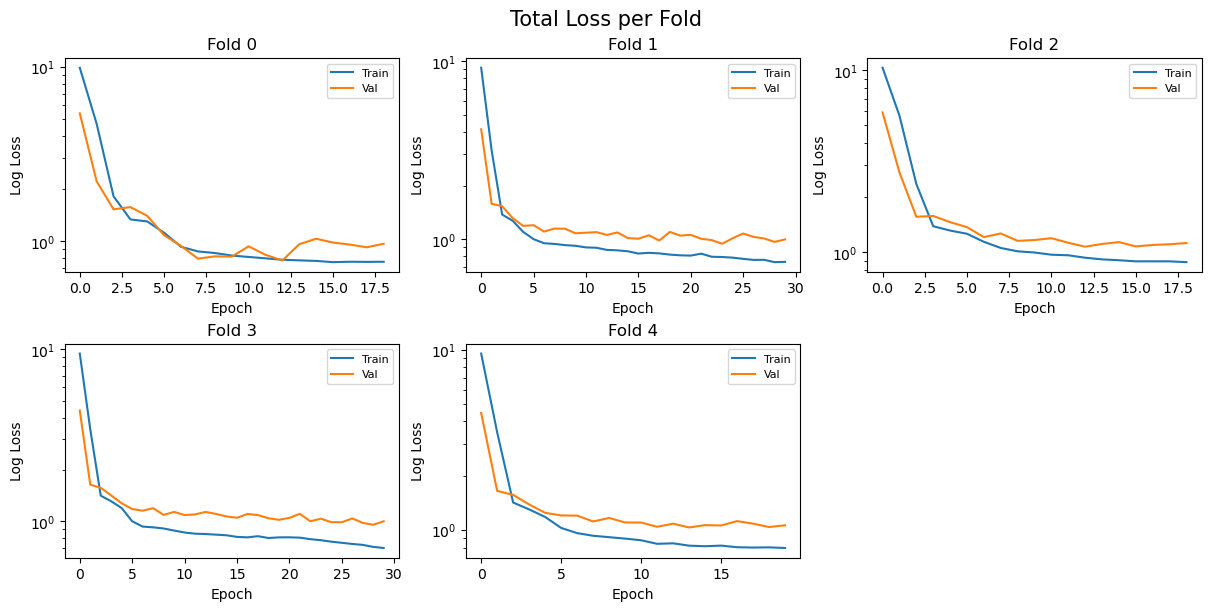

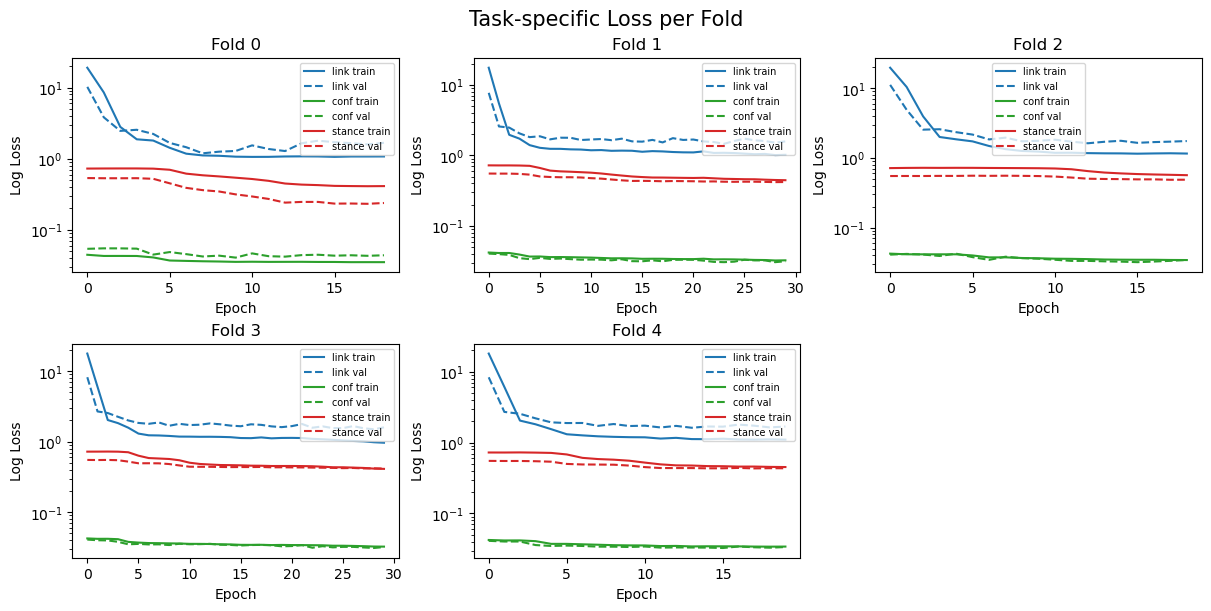

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()
try:
    # Start cross-validation training
    model_gcn, results_gcn, cv_history_gcn = train_gnn_live(
        all_graphs=graph_data.pyg_graphs,
        model_args=MODEL_ARGS,
        train_args=TRAIN_ARGS,
        model_class=MultitaskDebateGNN,
        live_plot=False,
    )
    plot_cv_losses(cv_history=cv_history_gcn)
    
except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
#   - Link Auc:         : 0.7072  3_GCN
#   - Link Auc:        : 0.8941  3_SAGE
# *** Average Test Performance *** 3_ECC
#   - Conf Mae            : 0.3350
#   - Conf Nll            : 0.7271
#   - Link Auc            : 0.8395
#   - Stance Kl           : 0.6248
#   - Stance Nll          : 0.6327
# *** Average Test Performance *** 2_SAGE_1_ECC
#   - Conf Mae            : 0.3445
#   - Conf Nll            : 0.7131
#   - Link Auc            : 0.8785
#   - Stance Kl           : 0.5844
#   - Stance Nll          : 0.5923
# *** Average Test Performance *** 1_ECC_2_SAGE
#   - Conf Mae            : 0.3519
#   - Conf Nll            : 0.7175
#   - Link Auc            : 0.8902
#   - Stance Kl           : 0.9766
#   - Stance Nll          : 0.9845
# *** Average Test Performance ***  1_SAGE_2_ECC
#   - Conf Mae            : 0.3341
#   - Conf Nll            : 0.7573
#   - Link Auc            : 0.8147
#   - Stance Kl           : 0.6429
#   - Stance Nll          : 0.6508